## Evaluation of a function in a periodic grid

This example illustrates how to evaluate a function in a periodic grid. In this case, the interaction of an atomic nucleus with the electron density of the crystal is evaluated. In this case the electron density of the unit cell is treated as periodic.

### Defining the grid describing the unit cell

A uniform grid using Grid is defined with the points for which the electron density was returned by GPAW.

In [6]:
import numpy as np
from grid.cubic import UniformGrid
from grid.periodicgrid import PeriodicGrid
from gpaw import restart
from ase.units import Bohr

NaCl, calculator = restart('nacl.gpw', txt=None)

# get atomic coordinates and numbers
atnums = NaCl.get_atomic_numbers()              
atcoords = NaCl.get_positions(wrap=True) / Bohr 

# set grid refinement factor for computing the electron density grid
gridrefinement = 1
# calculate the electron density (GPAW)
density=calculator.get_all_electron_density(gridrefinement=gridrefinement)
# compute reference charge (GPAW)
dv = NaCl.get_volume() / calculator.get_number_of_grid_points().prod() # volume element
cell_charge = density.sum() * dv / gridrefinement**3
print("Number of electrons in the cell (from GPAW):", cell_charge)


# get grid uniform grid axes
cellvects=calculator.density.gd.cell_cv         # cell vectors
shape = np.array(density.shape)                 # shape of the density array
axes = cellvects / shape                        # axes of the density array

density_au = density.flatten() * (Bohr**3) # flatten density and convert to atomic units

# create a grid object (UniformGrid) with the standard Riemannian weights
grid_st = UniformGrid(origin=np.zeros(3), axes=axes, shape=shape, weight="Rectangle")

print("Number of electrons in the cell (using Riemannian weights):", grid_st.integrate(density_au))
print("The GPAW integration corresponds to the standard Rieman Integral\n")

Number of electrons in the cell (from GPAW): 112.0000033428932
Number of electrons in the cell (using Riemannian weights): 112.0000033428934
The GPAW integration corresponds to the standard Rieman Integral



#### Evaluating the periodic property

With the uniform grid a periodic grid can be constructed where the electron density (any property) can be projected outside the unit cell boundaries. In the following example, several cuttoff radii are used to project the electron density outside the unit cell boundaries (and withing the sphere defined by the cutoff radius). Here the electron density is plotted for the points along the x-axis (the y and z coordinates are set to zero) for the different cutoff radii.

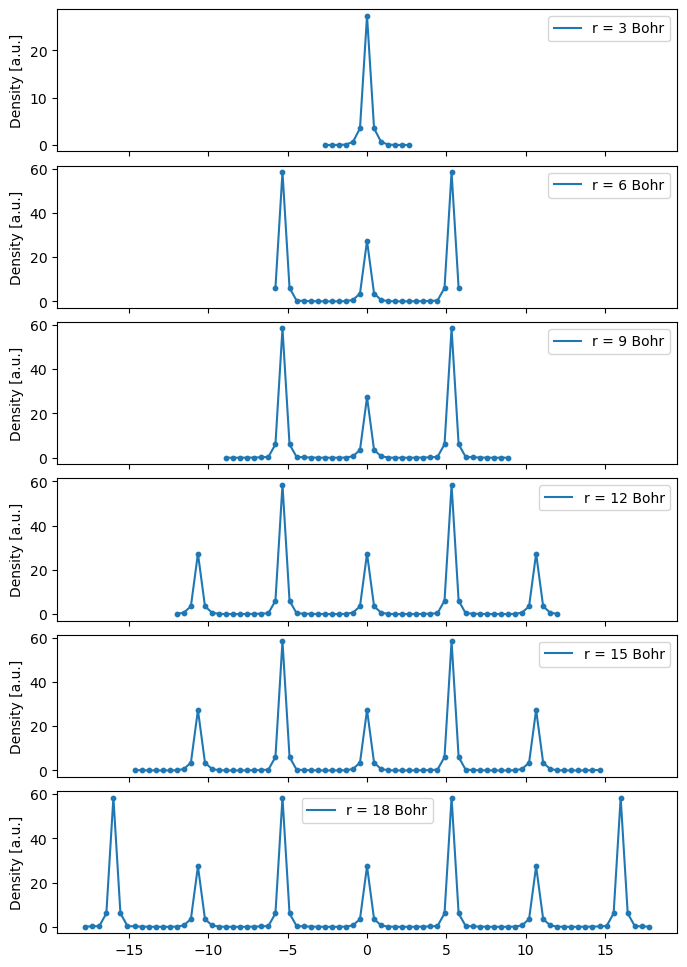

In [7]:
origin = np.array([0.0, 0.0, 0.0])

# create a grid object (PeriodicGrid) with the electron density
pgrid = PeriodicGrid(points=grid_st.points, weights=grid_st.weights, realvecs=cellvects)

data = {}
for rad in 3 * np.arange(1, 7):
    # get local grid with radius of i Bohr and center displaced by a small amount from the atom
    localgrid = pgrid.get_localgrid(origin,rad)
    # get density values for the points in the local grid
    local_density = density_au[localgrid.indices]
    # get local indices of points where y = 0 and z = 0
    x_indices = (localgrid.points[:, 1] == 0) & (localgrid.points[:, 2] == 0)
    # get the x coordinates of the points where y = 0 and z = 0
    x = localgrid.points[x_indices][:, 0]
    # get the density values at the points where y = 0 and z = 0
    local_density_x = local_density[x_indices]
    data[rad] = np.array([x, local_density_x])


# plot the density along the x-axis for different radii
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(8, 12))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.1)
for ax, rad in zip(axs, data.keys()):
    x_vals = sorted(data[rad][0])
    density_vals = data[rad][1][np.argsort(data[rad][0])]
    ax.plot(x_vals, density_vals, label=f"r = {rad} Bohr")
    ax.scatter(x_vals, density_vals, s=10)
    ax.set_ylabel("Density [a.u.]")
    ax.legend()
